## 根画像抽出プログラム ver.1

根部分のみ抽出、ただし、
- ヒゲ根は収縮膨張によりカットする。カット基準は、面積が2/3になるまで収縮し、その過程で消えた部分はカット。のち、同じ回数膨張させてほぼ元の根形に戻す。
- OpenCV の cv2.fitEllipse 関数で図形を囲む最小矩形を求め、長軸が垂直になるように回転する。

### 前提
- 概ね根が下になるように撮影された画像であることを前提としている。

### わかっている問題点
- 形状しか見ていないので、球に近いものは軸方向が根軸から大きくずれる
- 角笛状のものはそもそも楕円形近似が適さないし、どちらを上にすべきかはなんとも言えない。

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
import pandas as pd
import os

# この関数は画像の入った複数のフォルダが１つのフォルダに入っていることを前提としている。
#  指定フォルダ直下の画像ファイルは無視する。直下のフォルダの中しか見ず、さらにサブフォルダがあっても再帰的に探すようなことはしない。

def listimage(path='シルエット', needThum=False):

    directory = os.listdir(path)
    
    # まずフォルダを全部リストアップ　→ folders
    folders = []
    for x in os.listdir(path):  
        if os.path.isdir(path + '/'+x) and x[0] != '.' and x[0] !='_':  #パスに取り出したオブジェクトを足してフルパスに
            folders.append(path + '/'+x)
    # print(folders)

    # folders の各フォルダの中にある jpg ファイルをリストアップ → ffiles
    # ffiles はフォルダごとのリストのリスト
    ffiles = []
    for x in folders:
        files = []
        for f in os.listdir(x):
            entry = x + '/'+f
            if os.path.isfile(entry) and f[-4:]=='.jpg' and f[0] != '.':
                files.append(entry)
        ffiles.append(files)
    
    if needThum: # サムネイルの作成
        i = 0
        for cat in ffiles:
            # print(folders[i])
            sam = Image.new('RGB', (800,600),(0,0,0))
            row = col = 0
            for rad in cat:
                img = Image.open(rad, 'r')
                thumbnail_size = (100, 100)
                img.thumbnail(thumbnail_size)
                sam.paste(img,(col,row))
                col += 100
                if col == 800:
                    col = 0
                    row += 100
                # plt.imshow(sam)
            sam.save('{}THUM.png'.format(folders[i]), 'PNG')
            print("saved {}".format(folders[i]))
            i +=1

    return folders,ffiles

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

# mkparaimage で２枚並べた画像を表示
def imshowpara(img1,img2):
    plotimg(mkparaimage(img1,img2))

In [13]:
# メインプログラム

def batch(images, savedir='概形シルエット',interactive = True):
    # savedir 保存先
    # interactive 結果を１枚ずつ確認するかどうか
    
    for path in images:
        print(path)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img2 = makemargin(img) # 作業用のマージンを確保
    
        # ガウスぼかしを適用してシルエットを滑らかにする
        ksize = int(0.1*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
        img2 = cv2.GaussianBlur(img2,(ksize,ksize),0) # ガウスぼかしを適用
        _ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化

        # 収縮・膨張によりヒゲ根を除去する
        area0 = np.sum(img2) # img2 の画素数*255 になるはず
        kernel = np.ones((3,3),np.uint8) 
        tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
        area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
        n = 1
        while 3*area1  > 2*area0: # 面積が 2/3 以下になるまで繰り返す
            tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
            area1 = np.sum(tmpimg) 
            n += 1
        # print("収縮・膨張回数",n)
        img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる

        # 楕円近似で軸方向を求める
        # あらためて輪郭を求め直す
        _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
        # rect1 = cv2.minAreaRect(cnt[0])  # 回転を考慮した矩形を求める場合
        rect1 = cv2.fitEllipse(cnt[0]) # 楕円近似する
        box = np.int0(cv2.boxPoints(rect1))  # (対角点1,幅と高さ,回転角) から４点座標に変換
        #cimg = cv2.cvtColor(img3,cv2.COLOR_GRAY2BGR)
        #cimg = cv2.drawContours(cimg,[box],0,(255,0,0),2)
        # pltt.imshow(cimg)
        deg = rect1[2] if rect1[2]<90 else rect1[2]-180
        x0,y0 = rect1[0]        
        
        # 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
        # mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0) # アフィン変換マトリクス
        img4 = makemargin(img3,mr=2) # 作業用のマージンを確保
        h3,w3 = img3.shape[:2]
        h4,w4 = img4.shape[:2]
        mat = cv2.getRotationMatrix2D((x0+(w4-w3)/2,y0+(h4-h3)/2), deg, 1.0) # アフィン変換マトリクス

        # アフィン変換の適用
        outimg = cv2.warpAffine(img4, mat, (0,0))

        # 再び最小矩形を求めて切り出す。ただし、マージンを５つける
        _nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(outimg) 
        outimg = outimg[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]

        # 結果を保存する
        readdir,filename = os.path.split(path)
        _,subdir = os.path.split(readdir)
        os.makedirs(os.path.join(savedir,subdir), exist_ok=True) # 保存先フォルダがなければ作成
        cv2.imwrite(os.path.join(savedir,subdir,filename),outimg)
        
        if interactive:
            cv2.imshow(filename,mkparaimage(img,outimg))
            key = cv2.waitKey(0)
            cv2.destroyAllWindows()
            cv2.waitKey(1) 
            if key == 113: #  "Q" で終了する
                break


In [14]:
_dir,ffiles = listimage(path='シルエット', needThum=False)
batch(sum(ffiles,[]), savedir='概形シルエット',interactive = False)

シルエット/17Cylindric/17daruma2o05_l.jpg
シルエット/17Cylindric/17daruma3o01_l.jpg
シルエット/17Cylindric/17daruma3o02_l.jpg
シルエット/17Cylindric/17daruma3o03_l.jpg
シルエット/17Cylindric/17daruma3o05_l.jpg
シルエット/17Cylindric/17daruma3o09_l.jpg
シルエット/17Cylindric/17daruma6o09_l.jpg
シルエット/17Cylindric/17kohaku1o02_l.jpg
シルエット/17Cylindric/17kohaku1o09_l.jpg
シルエット/17Cylindric/17kohaku2o10_l.jpg
シルエット/17Cylindric/17makoto1o01_l.jpg
シルエット/17Cylindric/17makoto1o05_l.jpg
シルエット/17Cylindric/17makoto1o06_l.jpg
シルエット/17Cylindric/17makoto1o10_l.jpg
シルエット/17Cylindric/17makoto2o03_l.jpg
シルエット/17Cylindric/17makoto2o06_l.jpg
シルエット/17Cylindric/17santar2o09_l.jpg
シルエット/17Cylindric/17santar2o10_l.jpg
シルエット/17Cylindric/17sinsyt1o08_l.jpg
シルエット/17Cylindric/17tanabe1o01_l.jpg
シルエット/17Cylindric/17tanabe1o02_l.jpg
シルエット/17Cylindric/17tanabe1o05_l.jpg
シルエット/17Cylindric/17tanabe1o06_l.jpg
シルエット/17Cylindric/17tanabe1o07_l.jpg
シルエット/17Cylindric/17tanabe1o09_l.jpg
シルエット/17Cylindric/17tanabe1o10_l.jpg
シルエット/17Cylindric/17tanabe2o01_l.jpg
シ

シルエット/17Triagular/17kamedo2o09_l.jpg
シルエット/17Triagular/17kamedo2o10_l.jpg
シルエット/17Triagular/17tohong1o05_l.jpg
シルエット/17Triagular/17tohotn1o02_l.jpg
シルエット/17Triagular/17tohotn1o03_l.jpg
シルエット/17Triagular/17tohotn1o04_l.jpg
シルエット/17Triagular/17tohotn1o05_l.jpg
シルエット/17Triagular/17tohotn1o06_l.jpg
シルエット/17Apically/17daruma1o03_l.jpg
シルエット/17Apically/17daruma1o08_l.jpg
シルエット/17Apically/17daruma1o09_l.jpg
シルエット/17Apically/17daruma4o02_l.jpg
シルエット/17Apically/17daruma4o06_l.jpg
シルエット/17Apically/17daruma4o08_l.jpg
シルエット/17Apically/17daruma5o03_l.jpg
シルエット/17Apically/17daruma6o06_l.jpg
シルエット/17Apically/17tohodm1o05_l.jpg


In [248]:
_dir,ffiles = listimage(path='概形シルエット', needThum=False)

saved 概形シルエット/17Cylindric
saved 概形シルエット/17Conv_tri
saved 概形シルエット/17Elliptic
saved 概形シルエット/17Horn
saved 概形シルエット/17Inv_tri
saved 概形シルエット/17Spheric
saved 概形シルエット/17Tran_ellip
saved 概形シルエット/17Triagular
saved 概形シルエット/17Apically


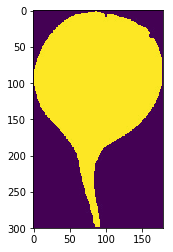

In [197]:
topdir = "シルエット"
subdir = "17Spheric"
filename = "17heians1o02_l.jpg"
path = os.path.join(topdir,subdir,filename)
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

418 15


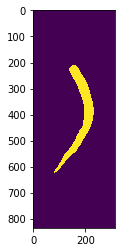

In [289]:
# 大抵の画像処理は画像枠近傍は処理結果がおかしくなるのでマージンをつける
def makemargin(img):
    h,w = img.shape[:2]
    w2 = 2*w
    h2 = 2*h
    img2 = np.zeros((h2,w2),np.uint8)
    img2[int(h/2):int(h/2)+h,int(w/2):int(w/2)+w] = img
    return img2

img2 = makemargin(img)
ksize = int(0.1*img.shape[1]/2)*2+1
print(img.shape[0],ksize)
img2 = cv2.GaussianBlur(img2,(ksize,ksize),0)
_ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)
plt.imshow(img2)

27227.0 26275.0
収縮・膨張回数 11
元の重心位置  252.02787674000072 177.2556286039593
変形後の重心位置  245.75589251439538 177.68971209213052
面積の変化 27227.0 -> 26050.0
面積の割合 0.956770852462629


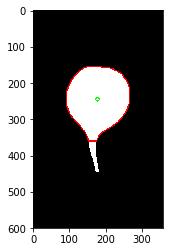

In [199]:
# ヒゲを除去

kernel = np.ones((3,3),np.uint8)
area0 = np.sum(img2/255)
oimg = cv2.erode(img2,kernel,iterations = 1)
area1 = np.sum(oimg/255)
print(area0,area1)

n = 1
while area1  > 2*area0/3:
    oimg = cv2.erode(oimg,kernel,iterations = 1)
    area1 = np.sum(oimg/255)
    n += 1
print("収縮・膨張回数",n)
oimg = cv2.dilate(oimg,kernel,iterations = n)
mm2 = cv2.moments(img2)
mom = cv2.moments(oimg)
area1 = np.sum(oimg/255)
print("元の重心位置 ",mm2['m01']/mm2['m00'],mm2['m10']/mm2['m00'])
print("変形後の重心位置 ",mom['m01']/mom['m00'],mom['m10']/mom['m00'])
print("面積の変化 {} -> {}".format(area0, area1))
# plt.imshow(oimg)
print("面積の割合",area1/area0)

pimg = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
_img,contours,hierarchy = cv2.findContours(oimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
pimg = cv2.drawContours(pimg,[contours[0]],0,(255,0,0),2)
pimg = cv2.circle(pimg,(int(mom['m10']/mom['m00']),int(mom['m01']/mom['m00'])),5,(0,255,0),2)

rect = cv2.boundingRect(contours[0])

plt.imshow(pimg)

array([[ 71, 324],
       [118, 130],
       [283, 170],
       [236, 364]])

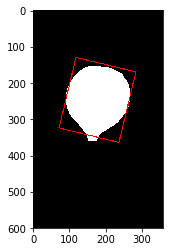

In [200]:
# 楕円近似で軸方向を求める
# あらためて輪郭を求め直す
_img,cnt,hierarchy = cv2.findContours(oimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
# rect1 = cv2.minAreaRect(cnt[0])  # 回転を考慮した矩形を求める
rect1 = cv2.fitEllipse(cnt[0]) # 楕円近似する
box = np.int0(cv2.boxPoints(rect1))
pimg = cv2.cvtColor(oimg,cv2.COLOR_GRAY2BGR)
pimg = cv2.drawContours(pimg,[box],0,(255,0,0),2)
plt.imshow(pimg)
box

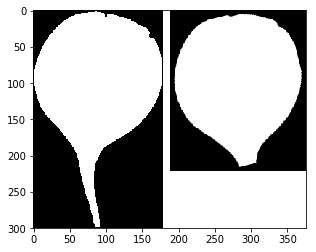

In [201]:
# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

deg = rect1[2]
x0,y0 = rect1[0]
ratio = 4
mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0)
outimg = cv2.warpAffine(oimg, mat, (0,0))
# 再び最小矩形を求めて切り出す。ただし、マージンを５つける
_nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(outimg) 
outimg = outimg[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]
plt.imshow(mkparaimage(img,outimg))

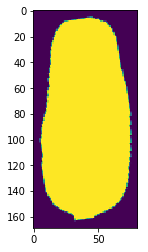

In [302]:
# 以上を一気に実行してみる

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

topdir = "シルエット"
subdir = "17Cylindric"
filename = "17yukibi1o08_l.jpg"

path = os.path.join(topdir,subdir,filename)
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# plt.imshow(img)

img2 = makemargin(img) # 作業用のマージンを確保

# ガウスぼかしを適用してシルエットを滑らかにする
ksize = int(0.1*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
# print(img.shape[0],ksize)
img2 = cv2.GaussianBlur(img2,(ksize,ksize),0) # ガウスぼかしを適用
_ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化
# plt.imshow(img2)

# 収縮・膨張によりヒゲ根を除去する
area0 = np.sum(img2) # img2 の画素数*255 になるはず
kernel = np.ones((3,3),np.uint8) 
tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
n = 1
while 3*area1  > 2*area0: # 面積が 2/3 以下になるまで繰り返す
    tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
    area1 = np.sum(tmpimg) 
    n += 1
# print("収縮・膨張回数",n)
img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる

# 楕円近似で軸方向を求める
# あらためて輪郭を求め直す
_img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
# rect1 = cv2.minAreaRect(cnt[0])  # 回転を考慮した矩形を求める場合
rect1 = cv2.fitEllipse(cnt[0]) # 楕円近似する
box = np.int0(cv2.boxPoints(rect1)) 
#cimg = cv2.cvtColor(img3,cv2.COLOR_GRAY2BGR)
#cimg = cv2.drawContours(cimg,[box],0,(255,0,0),2)
# plt.imshow(cimg)
deg = rect1[2]
x0,y0 = rect1[0]
mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0)
outimg = cv2.warpAffine(img3, mat, (0,0))
# 再び最小矩形を求めて切り出す。ただし、マージンを５つける
_nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(outimg) 
outimg = outimg[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]
plt.imshow(outimg)

In [209]:
rect1

((95.39210510253906, 188.8125762939453),
 (68.855712890625, 164.9580078125),
 8.717416763305664)

# 楕円近似の問題点

一つだけうまくいかない個体があったので解析

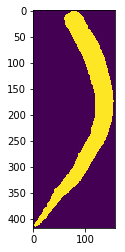

In [8]:
# 以上を一気に実行してみる

topdir = "シルエット"
subdir = "17Horn"
filename = "17aomida2o02_l.jpg"

path = os.path.join(topdir,subdir,filename)
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

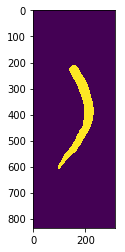

In [9]:
img2 = makemargin(img) # 作業用のマージンを確保
plt.imshow(img2)

# ガウスぼかしを適用してシルエットを滑らかにする
ksize = int(0.1*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
# print(img.shape[0],ksize)
img2 = cv2.GaussianBlur(img2,(ksize,ksize),0) # ガウスぼかしを適用
_ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化

# 収縮・膨張によりヒゲ根を除去する
area0 = np.sum(img2) # img2 の画素数*255 になるはず
kernel = np.ones((3,3),np.uint8) 
tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
n = 1
while 3*area1  > 2*area0: # 面積が 2/3 以下になるまで繰り返す
    tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
    area1 = np.sum(tmpimg) 
    n += 1
# print("収縮・膨張回数",n)
img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる

plt.imshow(img3)

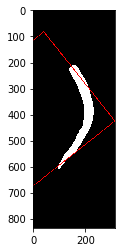

In [10]:
# 楕円近似で軸方向を求める
# あらためて輪郭を求め直す
_img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
# rect1 = cv2.minAreaRect(cnt[0])  # 回転を考慮した矩形を求める場合
rect1 = cv2.fitEllipse(cnt[0]) # 楕円近似する
box = np.int0(cv2.boxPoints(rect1)) 
cimg = cv2.cvtColor(img3,cv2.COLOR_GRAY2BGR)
cimg = cv2.drawContours(cimg,[box],0,(255,0,0),2)
plt.imshow(cimg)

In [11]:
deg = rect1[2]
x0,y0 = rect1[0]
mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0)

In [286]:
x0,y0

(-43.87461853027344, 430.52508544921875)

# なぜこうなるのか考察

与えられた各点との距離の総和が最小となる楕円を求めている。
通常の根形の場合、右側と右側の側面が楕円の向かい合う弧にフィッティングされるが、このようなホーン型の場合は、右側と左側がどちらもが同弧にフィッティングされたためと思われる。



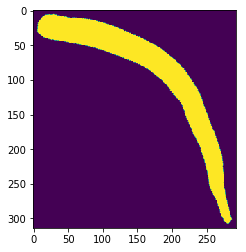

In [12]:
deg = rect1[2]
x0,y0 = rect1[0]

img4 = makemargin(img3,mr=2) # 作業用のマージンを確保
h3,w3 = img3.shape[:2]
h4,w4 = img4.shape[:2]
mat = cv2.getRotationMatrix2D((x0+(w4-w3)/2,y0+(h4-h3)/2), deg, 1.0)
outimg = cv2.warpAffine(img4, mat, (0,0))
# 再び最小矩形を求めて切り出す。ただし、マージンを５つける
_nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(outimg) 
outimg = outimg[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]
plt.imshow(outimg)

In [296]:
cv2.warpAffine(np.array(box),mat, (0,0))

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/imgwarp.cpp:1804: error: (-215:Assertion failed) ifunc != 0 in function 'remap'


In [299]:
mat

array([[   0.62281138,    0.78237202, -353.37978819],
       [  -0.78237202,    0.62281138,  128.0628873 ]])